In [68]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import imageio as iio
import pandas as pd
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torchvision.transforms as transforms
import skimage


In [69]:
from skimage.transform import resize

image_dir = os.getcwd()+"\\CNN\\train\\"

filenames = os.listdir(image_dir)
labels = [x.split(".")[0] for x in filenames]
img = [imread(image_dir + x) for x in filenames]

data = pd.DataFrame({"filename": filenames, "label": labels, "img": img})

for index, row in data.iterrows():
    img = imread(image_dir + row["filename"])
    img = resize(img, (80,80))
    data.loc[index, "img"] = img

data = data.reset_index()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5533 entries, 0 to 5532
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     5533 non-null   int64 
 1   filename  5533 non-null   object
 2   label     5533 non-null   object
 3   img       5533 non-null   object
dtypes: int64(1), object(3)
memory usage: 173.0+ KB


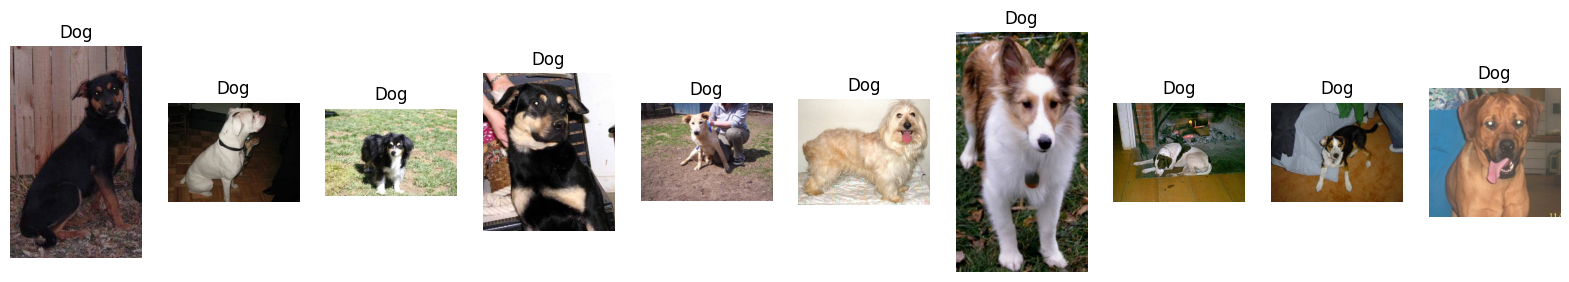

In [70]:
plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.subplots_adjust(hspace=0.4)

i = 0
j = 0 

while (i < 10):
    
    filename =  'dog.' + str(j) + '.jpg'
    j += 1
    if(os.path.exists(os.getcwd()+"\\CNN\\train\\"+filename) == False):
        continue

    plt.subplot(1,10,i+1)    # the number of images in the grid is 10*10 (100)
    i += 1

    image = imread("CNN\\train\\"+filename)
    plt.imshow(image)
    plt.title('Dog',fontsize=12)
    plt.axis('off')

plt.show()

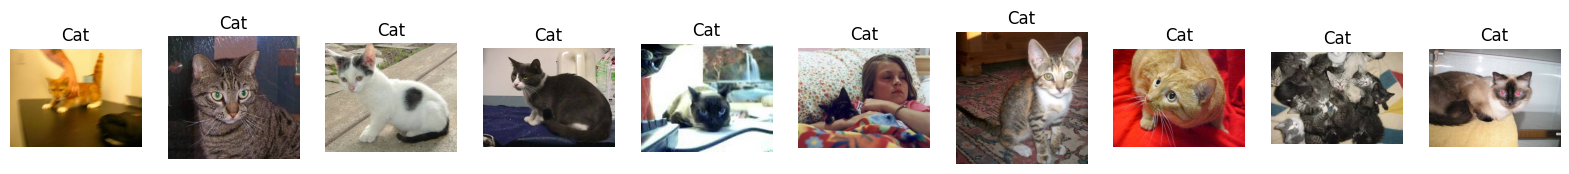

In [71]:
plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.subplots_adjust(hspace=0.4)

i = 0
j = 0 

while (i < 10):
    
    filename =  'cat.' + str(j) + '.jpg'
    j += 1
    if(os.path.exists(os.getcwd()+"\\CNN\\train\\"+filename) == False):
        continue

    plt.subplot(1,10,i+1)    # the number of images in the grid is 10*10 (100)
    i += 1

    image = imread("CNN\\train\\"+filename)
    plt.imshow(image)
    plt.title('Cat',fontsize=12)
    plt.axis('off')

plt.show()

In [83]:
train_images, test_images,train_labels, test_labels = train_test_split(
    np.array(data["img"]), 
    np.array(data["label"]), 
    random_state=104, 
    test_size=0.25, 
    shuffle=True)

train_images, test_images = train_images / 255.0, test_images / 255.0

In [84]:
from sklearn.base import BaseEstimator, TransformerMixin
from skimage.feature import hog
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [85]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
 
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step

X_train_gray = grayify.fit_transform(train_images)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape) 

(4149, 576)


In [86]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, train_labels)

SGDClassifier(random_state=42)

In [87]:
X_test_gray = grayify.transform(test_images)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

In [88]:
y_pred = sgd_clf.predict(X_test_prepared)
print(np.array(y_pred == test_labels)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == test_labels)/len(test_labels))

[False False False False False False  True  True False  True False False
  True  True  True  True  True  True  True  True  True  True  True  True
  True]

Percentage correct:  66.32947976878613


In [89]:
labels = ['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no',  'no', 'no', 'no']
predictions = ['yes', 'yes', 'yes', 'yes', 'no',  'no',  'yes', 'no', 'no', 'no']
 
# put the data in a dataframe for pretty printing
df = pd.DataFrame(
    np.c_[labels, predictions], 
    columns=['true_label', 'prediction']
)
df

,true_label,prediction
0,yes,yes
1,yes,yes
2,yes,yes
3,yes,yes
4,yes,no
5,yes,no
6,no,yes
7,no,no
8,no,no
9,no,no


In [90]:
from sklearn.metrics import confusion_matrix
 
label_names = ['yes', 'no']
cmx = confusion_matrix(labels, predictions, labels=label_names)
df = pd.DataFrame(cmx, columns=label_names, index=label_names)
df.columns.name = 'prediction'
df.index.name = 'label'
df

prediction,yes,no
label,,
yes,4,2
no,1,3


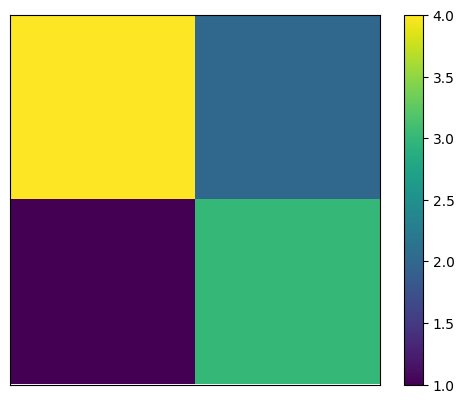

In [91]:
plt.imshow(cmx)
plt.xticks([])
plt.yticks([])
plt.colorbar()

In [92]:
cmx = confusion_matrix(test_labels, y_pred)
cmx

array([[476, 237],
       [229, 442]], dtype=int64)


 ['cat', 'dog']


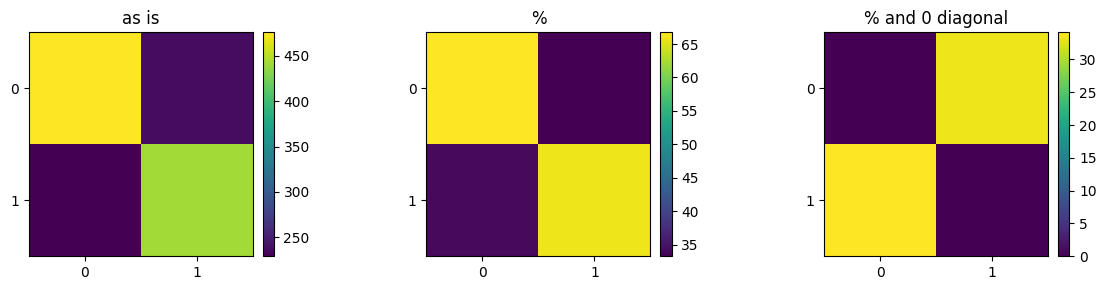

In [93]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
 
def plot_confusion_matrix(cmx, vmax1=None, vmax2=None, vmax3=None):
    cmx_norm = 100*cmx / cmx.sum(axis=1, keepdims=True)
    cmx_zero_diag = cmx_norm.copy()
 
    np.fill_diagonal(cmx_zero_diag, 0)
 
    fig, ax = plt.subplots(ncols=3)
    fig.set_size_inches(12, 3)
    [a.set_xticks(range(len(cmx)+1)) for a in ax]
    [a.set_yticks(range(len(cmx)+1)) for a in ax]
         
    im1 = ax[0].imshow(cmx, vmax=vmax1)
    ax[0].set_title('as is')
    im2 = ax[1].imshow(cmx_norm, vmax=vmax2)
    ax[1].set_title('%')
    im3 = ax[2].imshow(cmx_zero_diag, vmax=vmax3)
    ax[2].set_title('% and 0 diagonal')
 
    dividers = [make_axes_locatable(a) for a in ax]
    cax1, cax2, cax3 = [divider.append_axes("right", size="5%", pad=0.1) 
                        for divider in dividers]
 
    fig.colorbar(im1, cax=cax1)
    fig.colorbar(im2, cax=cax2)
    fig.colorbar(im3, cax=cax3)
    fig.tight_layout()
     
plot_confusion_matrix(cmx)
 
# the types appear in this order
print('\n', sorted(np.unique(test_labels)))